# Lesson 5: find a peak and lineup

In this lesson, alignment to a narrow diffraction peak is 
using capabilities provided by 
the [ophyd](https://blueskyproject.io/ophyd/) package.  The 
simulation consists of a simulated motor and simulated
noisy detector.

The noisy detector is configured to describe a narrow diffraction
peak with Gaussian profile based on the value of the motor position.
The peak is centered randomly somewhere between motor 
values -1 and +1.  The width is less than 0.05 in the same units.  The
peak intensity is expected to be approximately 100,000 (counts/sec 
are typical units).

**Preparation**

Make sure the `instrument` package is in the same directory 
as this jupyter notebook. The `instrument` package included with 
this lesson is a brief version of the standard package used 
with any APS instrument.  Since the notebook is for teaching,
it does not connect with any mongodb database.  The scans are 
not kept by the databroker.  However, every scan is saved to a 
SPEC data file as described when the instrument package is loaded.

## Objective

Use *Bluesky* (the tools provided by the various packages 
of the [Bluesky framework](https://blueskyproject.io/)) 
to find the center and width of a simulated diffraction 
peak.  Move the motor to the peak center.

1. Use interactive ophyd commands to find the peak and assess the width.
2. Use the RunEngine and bluesky plans to find the peak and assess the width.


## Advanced

3. Make a custom plan and run it to find the peak center.
4. Add that new plan to the instrument package, then 
   restart the notebook's kernel and try it.
5. Add the simulated motor and noisy detector to the 
   instrument package, then restart the notebook's 
   kernel and find the peak again.


----

## Initialize

Load the instrument controls (which sets up the Bluesky framework for collection: `RE`, `bec`, `bp`, ...).  This defines more than we need but works as a simple start, just like regular data acquisition at a beam line.

In [1]:
from instrument.collection import *

I Thu-15:05:04 - ############################################################ startup
I Thu-15:05:04 - logging started
I Thu-15:05:04 - logging level = 10
I Thu-15:05:04 - /home/beams1/JEMIAN/Documents/projects/use_bluesky/lessons/instrument/collection.py
I Thu-15:05:04 - /home/beams1/JEMIAN/Documents/projects/use_bluesky/lessons/instrument/mpl/notebook.py


Activating auto-logging. Current session state plus future input saved.
Filename       : /home/beams1/JEMIAN/Documents/projects/use_bluesky/lessons/.logs/ipython_console.log
Mode           : rotate
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


I Thu-15:05:05 - bluesky framework
I Thu-15:05:05 - /home/beams1/JEMIAN/Documents/projects/use_bluesky/lessons/instrument/framework/check_python.py
I Thu-15:05:05 - /home/beams1/JEMIAN/Documents/projects/use_bluesky/lessons/instrument/framework/check_bluesky.py
I Thu-15:05:06 - /home/beams1/JEMIAN/Documents/projects/use_bluesky/lessons/instrument/framework/initialize.py
I Thu-15:05:10 - /home/beams1/JEMIAN/Documents/projects/use_bluesky/lessons/instrument/framework/metadata.py
I Thu-15:05:10 - /home/beams1/JEMIAN/Documents/projects/use_bluesky/lessons/instrument/framework/callbacks.py
I Thu-15:05:10 - writing to SPEC file: /home/beams1/JEMIAN/Documents/projects/use_bluesky/lessons/20200507-150510.dat
I Thu-15:05:10 -    >>>>   Using default SPEC file name   <<<<
I Thu-15:05:10 -    file will be created when bluesky ends its next scan
I Thu-15:05:10 -    to change SPEC file, use command:   newSpecFile('title')


Numpy provides the random number generator we'll use.

In [2]:
import numpy as np

Load the ophyd simulators

In [3]:
from ophyd.sim import *

## Make a noisy detector

Make a new ``noisy``, replacing the one from the simulator.

In [4]:
noisy = SynGauss(
    'noisy', 
    motor, 'motor', 
    # center somewhere between -1 and 1
    center=2 * (np.random.random()-0.5), 
    # randomize these parameters
    Imax=100000 + 20000 * (np.random.random()-0.5),
    noise='poisson', 
    sigma=0.016 + 0.015 * (np.random.random()-0.5), 
    noise_multiplier=0.1 + 0.02 * (np.random.random()-0.5),
    labels={'detectors'})

Define the reported precision of the motor and detector.

In [5]:
motor.precision = 5
noisy.precision = 0

Print the values just configured

In [6]:
print(f"motor: {motor.position}")
print(f"center: {noisy.center.get()}")
print(f"sigma: {noisy.sigma.get()}")
print(f"Imax: {noisy.Imax.get()}")
print(f"noise: {noisy.noise.get()}")
print(f"noise_multiplier : {noisy.noise_multiplier.get()}")
noisy.trigger()     # update the "detector" value
print(f"noisy_det : {noisy.read()}")

motor: 0
center: -0.33578949501748534
sigma: 0.012125848316437635
Imax: 107764.89679193328
noise: poisson
noise_multiplier : 0.10232657360878442
noisy_det : OrderedDict([('noisy', {'value': 0, 'timestamp': 1588881921.4439235})])


## 1. Use `ophyd` commands

The first thing to learn is how to move the motor.  As typical of many control systems, there are several ways to do this.  We will focus on only two of these since we can apply them to both simulated motors *and* EPICS motors.

Different from a real motor, our simulated motor moves immediately, so motor velocity and acceleration are not involved.  Since the motor moves immediately, there is no discernable delay due to short or long motor motions.

**tip**: There are several ways to do most things but this tutorial focuses on just a few with the hope that these ways are both simple and reuseable.

### motor, move and get position

For a motor named `motor`, any of these two commands can 
be used in an interactive session to move the motor from 
its current position to `1.0`:
    
    motor.set(1)
    motor.set(1).wait()
    %mov motor 1

The `%mov` command is simplest so that is what we will use here.

**tip**: The `%mov` command is absolute move.  The `%movr` is a relative move.

Move the motor from where it is now, to 1, and print its position.

In [7]:
%mov motor 1
print(motor.position)

1


Move the motor to 0.

In [8]:
%mov motor 0
motor.position

0

### detector, count and get value

Above, we created a detector named `noisy` that simulates a *scaler* (detector that records a single integer number of detection events, usually the number of X-ray photons received).  Real scalers are told to measure for a fixed time interval.  Our simulator does not have that feature.

The simulated noisy detector computes its value for *counts* based on the position of the configured motor.

Show the name of the motor configured into the `noisy` detector.  Check that its name is `motor`.

In [9]:
print(noisy._motor)

SynAxis(prefix='', name='motor', read_attrs=['readback', 'setpoint'], configuration_attrs=['velocity', 'acceleration'])


The value (number of counts) is kept in `noisy.val`.  Show it's value now.  

**tip**: We can drop the `print()` wrapper if the command we use returns the value we'd print anyway.  Use this convenient shortcut.

In [10]:
noisy.val

SynSignal(name='noisy', parent='noisy', value=0, timestamp=1588881921.4439235)

We need to tell the detector to acquire data.  To acquire data, our simulator will re-compute its value based on the motor position (as with a real detector, the value does not update without something that compels this computation), since that may have changed since the last computation.

For ophyd Devices, the method to call is [`trigger()`](https://blueskyproject.io/ophyd/generated/ophyd.device.BlueskyInterface.trigger.html?highlight=trigger).

In [11]:
noisy.trigger()
noisy.val

SynSignal(name='noisy', parent='noisy', value=0, timestamp=1588881939.5872653)

### Find the simulated peak

With tools to move the motor and acquire data from the detector, we can try to find the simulated peak.  It may take some retries since the peak is narrow.  Take big steps first (such as `0.1`) to find non-zero counts, then smaller steps to find the peak.

First, move to one end of the range, then start stepping until you find non-zero counts.  Then use `%movr` and execute the same notebook cell repeatedly.  Call the detector's `.get()` method to only print the number of counts and not the other information.

In [20]:
%mov motor -1
noisy.trigger()
print(motor.position, noisy.val.get())

-1 0


In [45]:
%movr motor -0.0002
noisy.trigger()
print(f"{motor.position:.5f}, {noisy.val.get()}")

-0.33520, 107469


Compare the peak center you found with the value printed after the `noisy` detector was configured (above).  Probably, they will differ by a small amount since the simulator applies random noise to the signal.

## 2. Use RunEngine and bluesky plans

Here we use the RunEngine (`RE`) and standard [bluesky plans](https://blueskyproject.io/bluesky/plans.html) to locate the simulated diffraction peak.

Since we will do a series of scans, let's make a list to collect the results from each scan.  We'll report that list later.

In [46]:
results=[]

Next, some variables are defined which will make calling the scans more consistent.

The first variable, *k*, is used to expand (only slightly) the range of the next scan to better capture the full width of the peak.  We'll also define *n* as the number of points in each scan.

In [47]:
k = 1.5         # range expansion factor
n = 29          # number of points per scan

### Locate the approximate peak position

Scan from -2 to 2 to find the peak.  Since it is a Gaussian (which decays rapidly away from the peak), we may need to increase *n*, the number of points in the scan.  All we need is one point above the background to find it!

Use the [*scan*](https://blueskyproject.io/bluesky/generated/bluesky.plans.scan.html?highlight=scan) plan from `bluesky.plans` (provided here as `bp`) to locate at least one point on the peak that is above the background of 0 counts.



Transient Scan ID: 1     Time: 2020-05-07 15:08:27
Persistent Unique Scan ID: 'b5a31334-0061-47ae-9839-19b014b3739c'
New stream: 'primary'


<IPython.core.display.Javascript object>


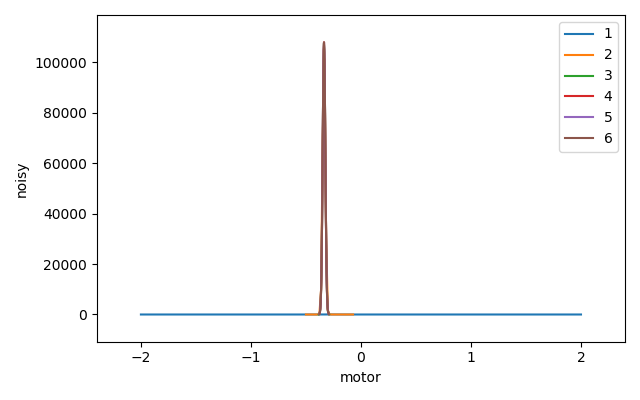

+-----------+------------+------------+------------+
|   seq_num |       time |      motor |      noisy |
+-----------+------------+------------+------------+
|         1 | 15:08:27.3 |   -2.00000 |          0 |
|         2 | 15:08:27.3 |   -1.85714 |          0 |
|         3 | 15:08:27.3 |   -1.71429 |          0 |
|         4 | 15:08:27.3 |   -1.57143 |          0 |
|         5 | 15:08:27.3 |   -1.42857 |          0 |
|         6 | 15:08:27.3 |   -1.28571 |          0 |
|         7 | 15:08:27.3 |   -1.14286 |          0 |
|         8 | 15:08:27.3 |   -1.00000 |          0 |
|         9 | 15:08:27.3 |   -0.85714 |          0 |
|        10 | 15:08:27.3 |   -0.71429 |          0 |
|        11 | 15:08:27.3 |   -0.57143 |          0 |
|        12 | 15:08:27.3 |   -0.42857 |          0 |
|        13 | 15:08:27.3 |   -0.28571 |         20 |
|        14 | 15:08:27.3 |   -0.14286 |          0 |
|        15 | 15:08:27.3 |    0.00000 |          0 |
|        16 | 15:08:27.3 |    0.14286 |       

('b5a31334-0061-47ae-9839-19b014b3739c',)

In [48]:
RE(bp.scan([noisy], motor, -2, 2, n))

One of the tools that works in the background of the Bluesky framework is the [*BestEffortCallback*](https://blueskyproject.io/bluesky/callbacks.html#best-effort-callback), known here as `bec`.  When `bec` is configured (see `instrument/framework/initialize.py`) as part of scanning with the RunEngine, it will assess peak parameters from each scan, where applicable.  The parameters are available in `bec.peaks` which we have, for convenience, defined as `peaks`.  We access a couple of those parameters here for peak center and width.

In [49]:
cen = peaks["cen"]["noisy"]
sigma = peaks["fwhm"]["noisy"]
results.append((RE.md["scan_id"], cen, sigma))
print(cen, sigma)

-0.2857142857142858 0.1428571428571428


### Refine the peak position

Refine the scan to the range of (-sigma .. +sigma) near the center of the previous scan.  Repeat as often as necessary to get the peak center and width.  Use the [*relative scan*](https://blueskyproject.io/bluesky/generated/bluesky.plans.rel_scan.html?highlight=rel_scan) plan from `bluesky.plans` to find the peak.

**tip**: Look for the plot in the cell above.  Replots will be drawn in different colors.  The legend indicates the `scan_id`.

In [54]:
%mov motor cen
RE(bp.rel_scan([noisy], motor, -k*sigma, k*sigma, n))

cen = peaks["cen"]["noisy"]
sigma = peaks["fwhm"]["noisy"]
results.append((RE.md["scan_id"], cen, sigma))
print(cen, sigma)



Transient Scan ID: 6     Time: 2020-05-07 15:09:04
Persistent Unique Scan ID: '10acf0c1-297e-40d6-af94-d8b70903f2f6'
New stream: 'primary'
+-----------+------------+------------+------------+
|   seq_num |       time |      motor |      noisy |
+-----------+------------+------------+------------+
|         1 | 15:09:04.6 |   -0.37860 |        210 |
|         2 | 15:09:04.6 |   -0.37555 |        489 |
|         3 | 15:09:04.6 |   -0.37249 |       1080 |
|         4 | 15:09:04.6 |   -0.36943 |       2252 |
|         5 | 15:09:04.6 |   -0.36637 |       4478 |
|         6 | 15:09:04.6 |   -0.36331 |       8399 |
|         7 | 15:09:04.6 |   -0.36025 |      14175 |
|         8 | 15:09:04.6 |   -0.35719 |      22582 |
|         9 | 15:09:04.6 |   -0.35414 |      34155 |
|        10 | 15:09:04.7 |   -0.35108 |      48986 |
|        11 | 15:09:04.7 |   -0.34802 |      64232 |
|        12 | 15:09:04.7 |   -0.34496 |      80679 |
|        13 | 15:09:04.7 |   -0.34190 |      94909 |
|        14

### Report the results

Print a nice table with the results from each of our scans.

In [55]:
tbl = pyRestTable.Table()
tbl.addLabel("scan ID")
tbl.addLabel("center")
tbl.addLabel("sigma")
for sid, cen, sigma in results:
    tbl.addRow((sid, cen, sigma))
print(tbl)

======= ==================== ====================
scan ID center               sigma               
======= ==================== ====================
1       -0.2857142857142858  0.1428571428571428  
2       -0.3363813081477674  0.031135955170103924
3       -0.3357830118007328  0.028682873180725543
4       -0.3357757049189273  0.028533683664144938
5       -0.33578446304651277 0.028546289554480186
6       -0.3357709072941233  0.028559157605062502
======= ==================== ====================

